In [3]:
# IV - 1 : Importinf of the librairy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from datetime import datetime
from keras.models import Sequential, Model,load_model
from keras.layers import Dropout,Dense
from keras import Input,layers
from keras.layers import LSTM, GRU,Bidirectional
from keras.layers import Conv1D,MaxPooling1D,GlobalMaxPooling1D
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score,make_scorer
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,StackingRegressor,VotingRegressor,GradientBoostingRegressor


In [4]:
#  IV - 2 : Importing the training set
dataset=pd.read_csv("https://raw.githubusercontent.com/oreilly-mlsec/book-resources/599669c7124dffb65ea7f6e0b7626df32496b1d6/chapter3/datasets/cpu-utilization/cpu-full-b.csv", sep=",")


In [5]:
# IV - 3 : split of data Test & Training

# Size the data Test, Training
train_size=int(len(dataset)*.85)
test_size=int(len(dataset)*.15)
x_trainning,x_testing=dataset.iloc[0:train_size],dataset.iloc[(train_size+1):(train_size+test_size)]

In [6]:
# IV - 4 : Preparing data for timesteps (lags)

def normalisationPreparationDonnee(data,lags):
    data=data['cpu'].values
    sc = MinMaxScaler(feature_range = (0, 1))
    #sc=StandardScaler()
    data1= data.reshape(-1,1)
    data2 = sc.fit_transform(data1)
    def preparation_data():
        x_train = []
        y_train = []
        for i in range(lags,len(data2)):
            x_train.append(data2[i-lags:i, 0])
            y_train.append(data2[i, 0])
        return np.array(x_train), np.array(y_train)
    x_train, y_train = preparation_data()
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    return x_train, y_train


In [7]:
# IV - 5 :Application

lags=5

x_train, y_train = normalisationPreparationDonnee(x_trainning, lags)
x_test, y_test = normalisationPreparationDonnee(x_testing, lags)


In [8]:
# IV - 7 : ENTRAINEMENT MODELE VOTING ET STACKING

In [9]:
# : Préparation des differents modèles 

def get_modelLSTM():
    modelLSTM = Sequential()
    modelLSTM.add(LSTM(units = 100, return_sequences = True, input_shape = (x_train.shape[1], 1)))
    modelLSTM.add(LSTM(units = 128, return_sequences = True))
    modelLSTM.add(LSTM(units = 64, return_sequences = True))
    modelLSTM.add(LSTM(units = 32, return_sequences = True))
    modelLSTM.add(LSTM(units = 64, return_sequences = True))
    modelLSTM.add(LSTM(units = 128, return_sequences = True))
    modelLSTM.add(LSTM(units = 100))
    modelLSTM.add(Dense(units = 1))
    modelLSTM.compile(optimizer = 'rmsprop', loss = 'mean_squared_error',
              metrics=['accuracy'])
    return modelLSTM 

def get_modelGRU():
    modelGRU = Sequential()
    modelGRU.add(GRU(units = 100, return_sequences = True, input_shape = (x_train.shape[1], 1)))
    modelGRU.add(GRU(units = 128, return_sequences = True))
    modelGRU.add(GRU(units = 64, return_sequences = True))
    modelGRU.add(GRU(units = 32, return_sequences = True))
    modelGRU.add(GRU(units = 64, return_sequences = True))
    modelGRU.add(GRU(units = 128, return_sequences = True))
    modelGRU.add(GRU(units = 100))
    modelGRU.add(Dense(units = 1))
    modelGRU.compile(optimizer = 'rmsprop', loss = 'mean_squared_error',
              metrics=['accuracy'])
    return modelGRU
    

def get_modelbidir():
    modelbidir = Sequential()
    modelbidir.add(Bidirectional(LSTM(units = 100, return_sequences = True, input_shape = (x_train.shape[1],1))))
    modelbidir.add(Bidirectional(LSTM(units = 128, return_sequences = True)))
    modelbidir.add(Bidirectional(LSTM(units = 64, return_sequences = True)))
    modelbidir.add(Bidirectional(LSTM(units = 32, return_sequences = True)))
    modelbidir.add(Bidirectional(LSTM(units = 64, return_sequences = True)))
    modelbidir.add(Bidirectional(LSTM(units = 128, return_sequences = True)))
    modelbidir.add(Bidirectional(LSTM(units = 100)))
    modelbidir.add(Dense(units = 1))
    modelbidir.compile(optimizer = 'adam', loss = 'mse',
              metrics=['accuracy'])
    return modelbidir

def get_modelConvNet1D():
    modelConvNet1D = Sequential()
    modelConvNet1D.add(Conv1D(100, kernel_size=1,activation='tanh',input_shape=(x_train.shape[1], 1)))
    modelConvNet1D.add(Conv1D(128, kernel_size=1,activation='tanh'))
    modelConvNet1D.add(MaxPooling1D(pool_size=2,strides=1,padding='same'))
    modelConvNet1D.add(Conv1D(64, kernel_size=1,activation='tanh'))
    modelConvNet1D.add(Conv1D(32, kernel_size=1,activation='tanh'))
    modelConvNet1D.add(Conv1D(64, kernel_size=1,activation='tanh'))
    modelConvNet1D.add(Conv1D(128, kernel_size=1,activation='tanh'))
    modelConvNet1D.add(MaxPooling1D(pool_size=2,strides=1,padding='same'))
    modelConvNet1D.add(GlobalMaxPooling1D())#modelConvNet1D.add(Flatten()) # pas besoin si globalMaxPooling1D est deja là
    modelConvNet1D.add(Dense(128,activation='tanh'))
    modelConvNet1D.add(Dense(100,activation='tanh'))
    modelConvNet1D.add(Dense(1))
    modelConvNet1D.compile(optimizer = 'adam', loss = 'mse',
              metrics=['accuracy'])
    return modelConvNet1D



In [10]:
# Application du regressor de keras 

model_lstm=KerasRegressor(build_fn=get_modelLSTM,validation_split=0.20,batch_size = 5,epochs=200,verbose=0)
model_gru=KerasRegressor(build_fn=get_modelGRU,validation_split=0.20,batch_size = 5,epochs=200,verbose=0)
model_bidir=KerasRegressor(build_fn=get_modelbidir,validation_split=0.20,batch_size = 5,epochs=500,verbose=0)
model_conv=KerasRegressor(build_fn=get_modelConvNet1D,validation_split=0.20,batch_size = 5,epochs=500,verbose=0)
# verbose=0 pour ne pas afficher le processus d'apprentissage par epoch.

In [11]:
# convertion de KerasRegressor en regressor

model_lstm._estimator_type = "regressor"
model_gru._estimator_type = "regressor"
model_bidir._estimator_type = "regressor"
model_conv._estimator_type = "regressor"


In [12]:
# estimator=estimator
# IV -7.1 : Application du voting Regressor 


In [13]:
start=time()
voting_reg = VotingRegressor( estimators=[('lstm', model_lstm),
                                          ('gru', model_gru),
                                          ('bidir', model_bidir),
                                          ('con',model_conv)]
                            )
voting_reg.fit(x_train, y_train) 
elapsed=time()-start
print('duree totale est de :',elapsed/60)


duree totale est de : 48.21050520737966


In [14]:
#  : Calculating Errors and Viewing Model Fits
# on Training and Test data(identical reference for all methods)

def ErreurPrediction(Nommodele,data,prediction ):
    print('La R^2-Squared(r2_score) du modèle {} est : {}'.format(Nommodele,r2_score(data,prediction)))
    print('La MAE modèle {} est de: {} '.format(Nommodele,mean_absolute_error(data,prediction)))
    print('La MSE modèle {} est de: {} '.format(Nommodele,mean_squared_error(data,prediction)))
    print('RMSE est:{}'.format(np.sqrt(mean_squared_error(data,prediction))))
   
def Affichage_Model(modelLSTM,NomDumodele):
    y_pred_train=modelLSTM.predict(x_train)
    y_pred_test=modelLSTM.predict(x_test)
    plt.figure(figsize=(18,7))
    plt.subplot(1,2,1)
    plt.plot(y_train, color = 'green', label = 'Données réelles en % CPU')
    plt.plot(y_pred_train, color = 'blue', label = 'Prédiction du modèle {}'.format(NomDumodele))
    plt.title('Modèle {} : Data training'.format(NomDumodele))
    plt.xlabel('Temps')
    plt.ylabel('% CPU')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(y_test, color = 'green', label = 'Données réelles en % CPU')
    plt.plot(y_pred_test, color = 'blue', label = 'Prédiction du modèle {} '.format(NomDumodele))
    plt.title('Modèle {} :Data Test'.format(NomDumodele))
    plt.xlabel('Temps')
    plt.ylabel('% CPU')
    plt.legend()

La R^2-Squared(r2_score) du modèle Erreur données entrainement voting est : 0.9709918670722979
La MAE modèle Erreur données entrainement voting est de: 0.0277924940256561 
La MSE modèle Erreur données entrainement voting est de: 0.0017997953236557427 
RMSE est:0.042423994668769026
La R^2-Squared(r2_score) du modèle Erreur données test est : 0.812997918645854
La MAE modèle Erreur données test est de: 0.06968265948573932 
La MSE modèle Erreur données test est de: 0.014540961604686585 
RMSE est:0.1205859096440649


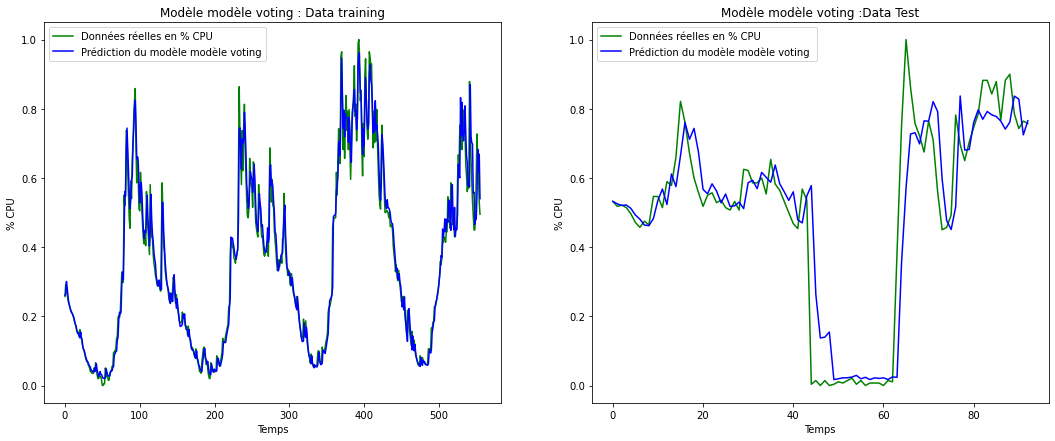

In [15]:
# Affichage des erreurs
ErreurPrediction("Erreur données entrainement voting",y_train,voting_reg.predict(x_train))
ErreurPrediction("Erreur données test",y_test,voting_reg.predict(x_test))
Affichage_Model(voting_reg,"modèle voting")

In [16]:
# IV -7.2 : Application du Stacking Regressor 


In [17]:
#  Application du Stacking Regressor  avec Random forest


In [18]:
start=time()

stacking_reg_RF = StackingRegressor( estimators=[
                                          ('bidir', model_bidir),
                                          ('con',model_conv)],
                                 final_estimator=RandomForestRegressor(n_estimators=300, random_state=42),cv=2)
stacking_reg_RF.fit(x_train, y_train)

elapsedRf=time()-start
print('duree totale est de :',elapsedRf/60)


duree totale est de : 76.9215113679568


La R^2-Squared(r2_score) du modèle Erreur données entrainement stacking RF est : 0.9037949477907629
La MAE modèle Erreur données entrainement stacking RF est de: 0.0529947859893902 
La MSE modèle Erreur données entrainement stacking RF est de: 0.005968995092162161 
RMSE est:0.07725927188475284
La R^2-Squared(r2_score) du modèle Erreur données test RF est : 0.8313928375262287
La MAE modèle Erreur données test RF est de: 0.07022619952727512 
La MSE modèle Erreur données test RF est de: 0.013110604213881416 
RMSE est:0.1145015467750607


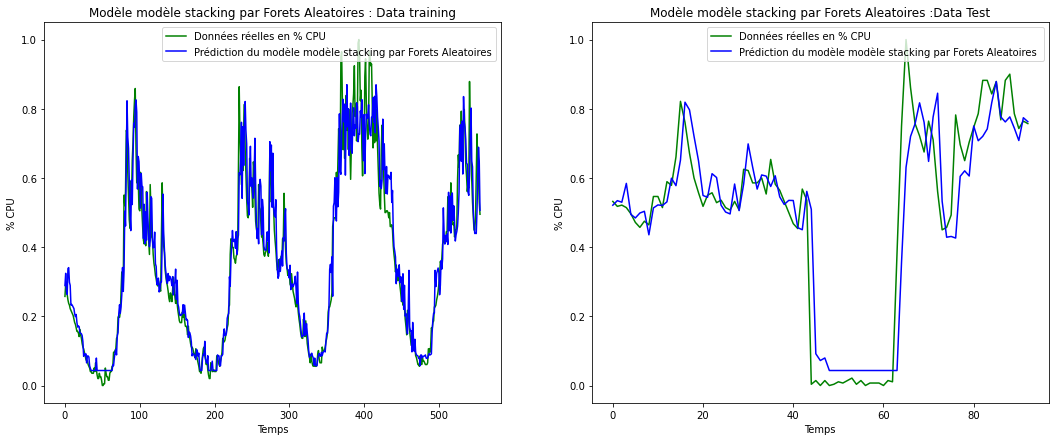

In [19]:
ErreurPrediction("Erreur données entrainement stacking RF",y_train,stacking_reg_RF.predict(x_train))
ErreurPrediction("Erreur données test RF",y_test,stacking_reg_RF.predict(x_test))
Affichage_Model(stacking_reg_RF,"modèle stacking par Forets Aleatoires")

In [20]:
# Application du Stacking Regressor  avec Regression lineaire

start=time()

stacking_reg_REGL = StackingRegressor( estimators=[('bidir', model_bidir),
                                          ('con',model_conv)],
                                 final_estimator=LinearRegression(),cv=2)

stacking_reg_REGL.fit(x_train, y_train)

elapsedRGL=time()-start

print('duree totale est de :',elapsedRGL/60)


duree totale est de : 103.75938047568003


La R^2-Squared(r2_score) du modèle Erreur données entrainement stacking REGL est : 0.926015547021387
La MAE modèle Erreur données entrainement stacking REGL est de: 0.048449577876022776 
La MSE modèle Erreur données entrainement stacking REGL est de: 0.004590328954504135 
RMSE est:0.06775196642536757
La R^2-Squared(r2_score) du modèle Erreur données test REGL est : 0.7840732032875157
La MAE modèle Erreur données test REGL est de: 0.07778048990280031 
La MSE modèle Erreur données test REGL est de: 0.01679009793732217 
RMSE est:0.12957661030186804


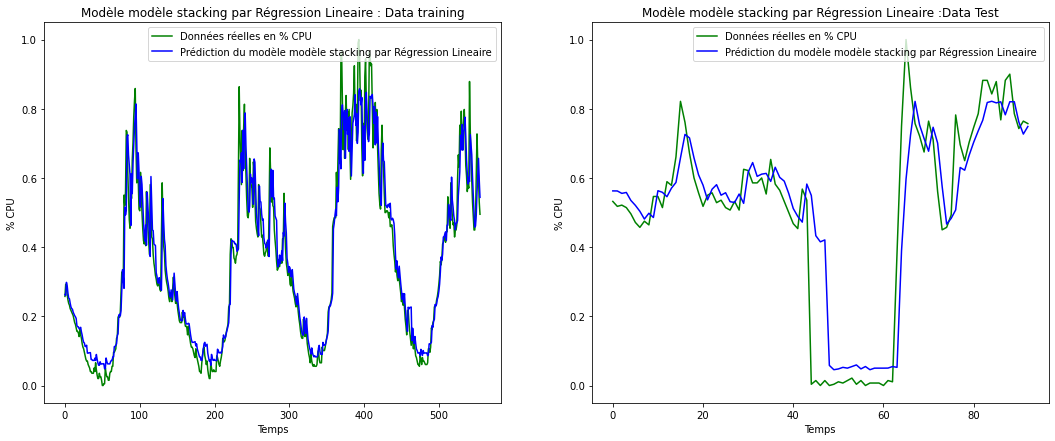

In [21]:
ErreurPrediction("Erreur données entrainement stacking REGL",y_train,stacking_reg_REGL.predict(x_train))
ErreurPrediction("Erreur données test REGL",y_test,stacking_reg_REGL.predict(x_test))
Affichage_Model(stacking_reg_REGL,"modèle stacking par Régression Lineaire")

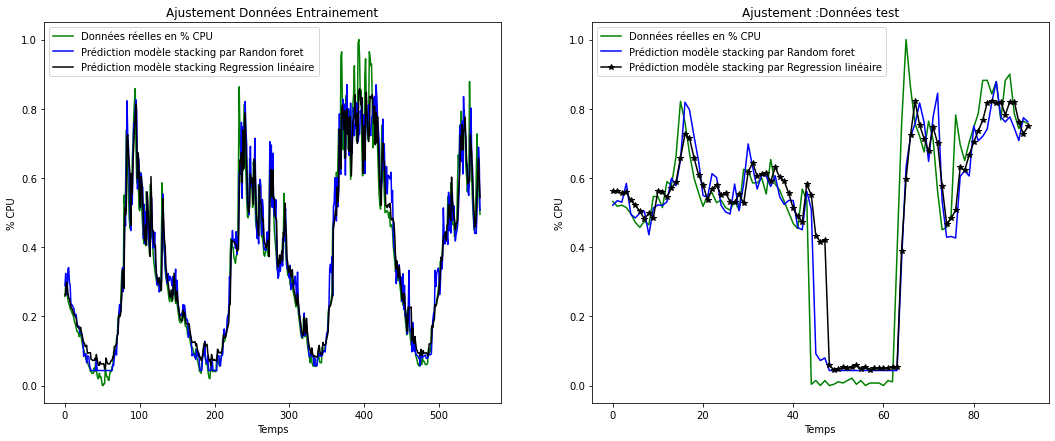

In [22]:
# A3 :  COMPARAISON DE STACKING SUR RONDOM FOREST ET REGRESSION LINEAIRE

plt.figure(figsize=(18,7))
plt.subplot(1,2,1)
plt.plot(y_train, color = 'green', label = 'Données réelles en % CPU')
plt.plot(stacking_reg_RF.predict(x_train), color = 'blue', label = 'Prédiction modèle stacking par Randon foret')
plt.plot(stacking_reg_REGL.predict(x_train), color = 'black', label = 'Prédiction modèle stacking Regression linéaire')
plt.title('Ajustement Données Entrainement')
plt.xlabel('Temps')
plt.ylabel('% CPU')
plt.legend()
plt.subplot(1,2,2)
plt.plot(y_test, color = 'green', label = 'Données réelles en % CPU')
plt.plot(stacking_reg_RF.predict(x_test), color = 'blue', label = 'Prédiction modèle stacking par Random foret')
plt.plot(stacking_reg_REGL.predict(x_test), color = 'black',marker='*', label = 'Prédiction modèle stacking par Regression linéaire')
plt.title('Ajustement :Données test')
plt.xlabel('Temps')
plt.ylabel('% CPU')
plt.legend()
plt.show()


In [23]:

start=time()
stacking_reg_xgboost = StackingRegressor( estimators=[                                        
                                          ('bidir', model_bidir),
                                          ('con',model_conv)],
                                 final_estimator=GradientBoostingRegressor(loss='quantile',criterion='mse', alpha=0.9,
                                n_estimators=300, max_depth=20,learning_rate=0.1, min_samples_leaf=3,
                                min_samples_split=20,
                                max_features='log2'), cv=2)
stacking_reg_xgboost.fit(x_train, y_train)
elapsed=time()-start

print('duree totale est de :',elapsed/60)



duree totale est de : 78.02993895610173


La R^2-Squared(r2_score) du modèle Erreur données entrainement stacking XGBoost est : 0.8222561614399831
La MAE modèle Erreur données entrainement stacking XGBoost est de: 0.07129667144417812 
La MSE modèle Erreur données entrainement stacking XGBoost est de: 0.011028028940926419 
RMSE est:0.10501442253769917
La R^2-Squared(r2_score) du modèle Erreur données test est : 0.605029492169927
La MAE modèle Erreur données test est de: 0.13251677281147237 
La MSE modèle Erreur données test est de: 0.030712230301137892 
RMSE est:0.17524905221181053


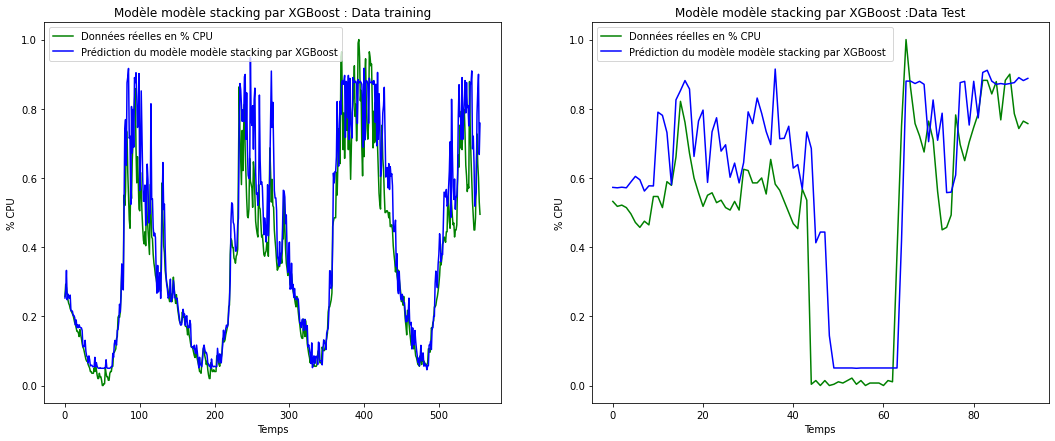

In [24]:
ErreurPrediction("Erreur données entrainement stacking XGBoost",y_train,stacking_reg_xgboost.predict(x_train))
ErreurPrediction("Erreur données test",y_test,stacking_reg_xgboost.predict(x_test))
Affichage_Model(stacking_reg_xgboost,"modèle stacking par XGBoost")